<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from random import seed
from random import randint
from tensorflow import keras
from keras import layers, models, utils, datasets
from keras import utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
%store -r scoring X X_train X_val CV t t_val f n 



#### Validación cruzada 

In [3]:
modelKNN = KNeighborsClassifier(round(np.sqrt((f-1)*n)))
scoresKNN = cross_validate(modelKNN, X, t, cv=CV, scoring=scoring)
print('Media del KNN : ', np.mean(scoresKNN['test_accuracy']))

# Guarda los valores de cada fold: 
df = pd.DataFrame.from_dict(scoresKNN)
df.drop(df.iloc[:, 0:2], inplace = True, axis = 1)
df.loc[5]=[np.mean(scoresKNN['test_recall_macro']),np.mean(scoresKNN['test_precision_macro']),np.mean(scoresKNN['test_f1_macro']),np.mean(scoresKNN['test_accuracy']),np.mean(scoresKNN['test_roc_auc_ovo'])]
df.index = ["CV 1","CV 2","CV 3","CV 4","CV 5","Average"]
df.to_excel("./informe/tables/KNN.xlsx") 
print(df)

Media del KNN :  0.6772222222222222
         test_recall_macro  test_precision_macro  test_f1_macro  \
CV 1              0.675926              0.720050       0.664506   
CV 2              0.665741              0.703508       0.652739   
CV 3              0.679630              0.724829       0.668267   
CV 4              0.681481              0.730804       0.668852   
CV 5              0.683333              0.721580       0.670704   
Average           0.677222              0.720154       0.665014   

         test_accuracy  test_roc_auc_ovo  
CV 1          0.675926          0.887653  
CV 2          0.665741          0.881247  
CV 3          0.679630          0.888029  
CV 4          0.681481          0.887236  
CV 5          0.683333          0.882288  
Average       0.677222          0.885291  


### Analisis hiper-parametros KNN

In [7]:
param_grid = {
    "leaf_size": list(range(1,50,10)),
    "n_neighbors": list(range(1,round(np.sqrt((f-1)*n)),8)),
    "p":[1,2]
}
search = GridSearchCV(estimator = modelKNN, param_grid =param_grid, n_jobs=-1,cv=CV,scoring=scoring,verbose=1,refit=False,return_train_score=False)
search_results = search.fit(X,t)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


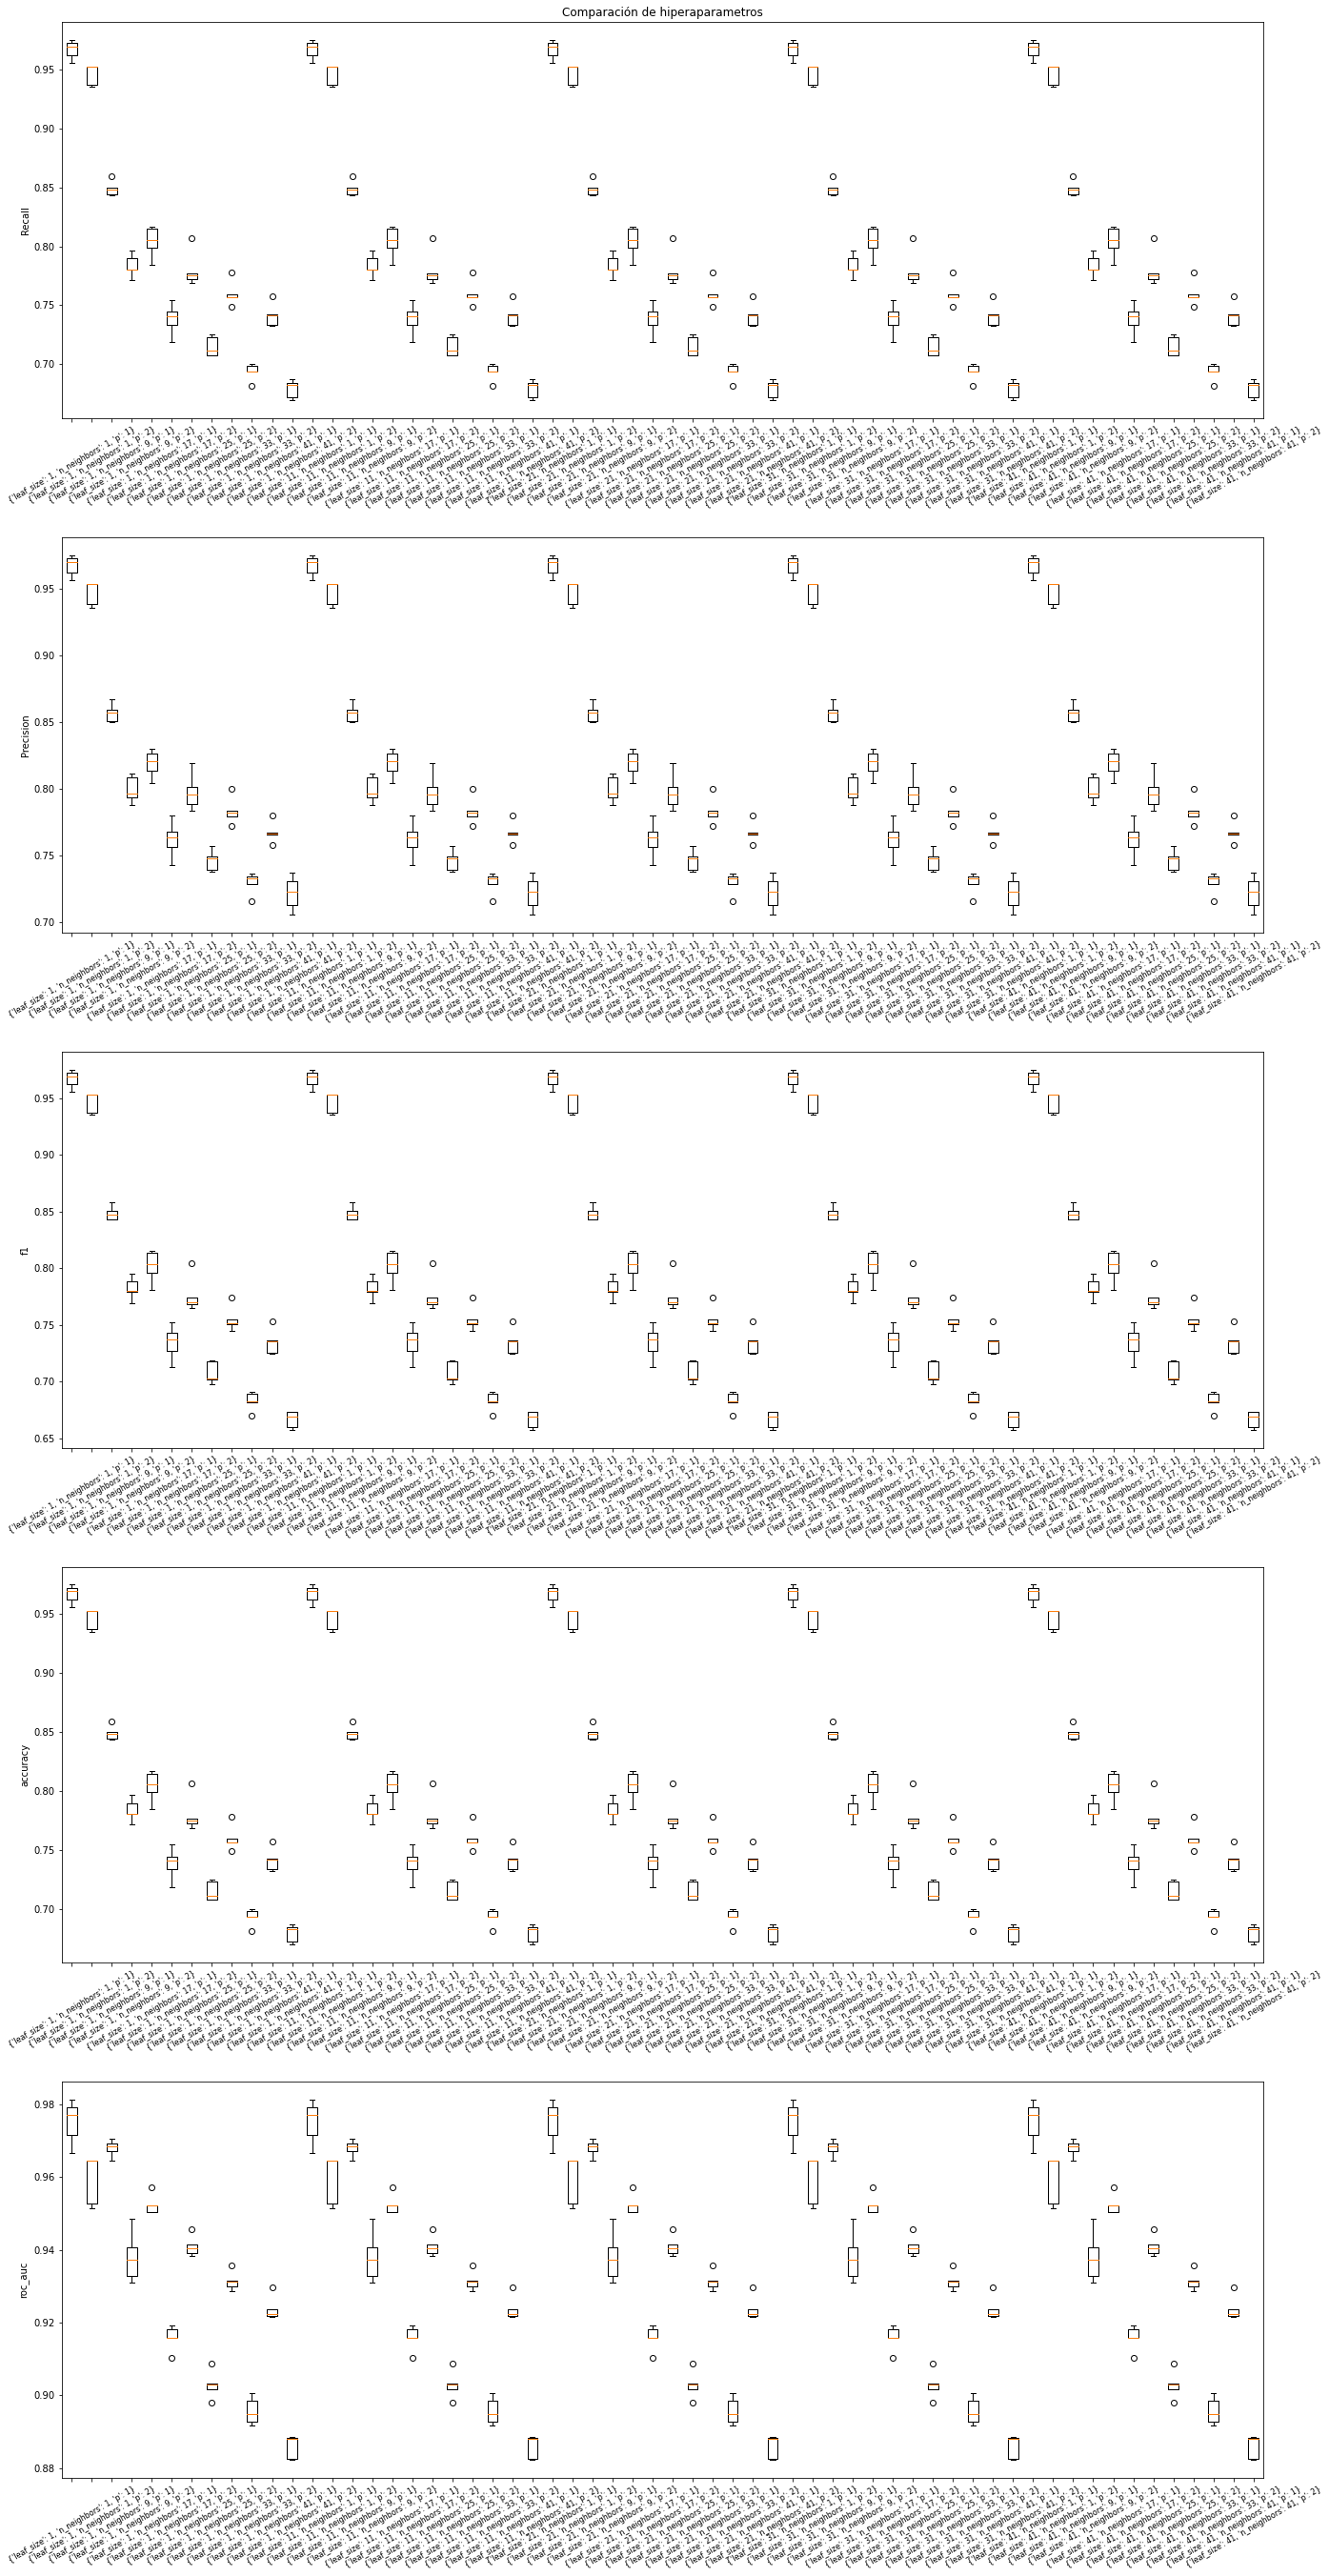

In [14]:

df = pd.DataFrame.from_dict(search_results.cv_results_)
df.to_excel("./informe/tables/parameters_knn.xlsx") 
labels = df['params']

data_recall =[]
data_precision = []
data_f1 =[]
data_accuracy = []
data_roc_auc  =[]


for c in range(len(labels)): 
    data_recall.append(df.iloc[c,8:13].to_list())  
    data_precision.append(df.iloc[c,16:21].to_list())  
    data_f1.append(df.iloc[c,24:29].to_list())  
    data_accuracy.append(df.iloc[c,32:37].to_list())  
    data_roc_auc.append(df.iloc[c,40:45].to_list())    





fig, ax = plt.subplots(5,1)

ax[0].boxplot(data_recall,labels=labels)
ax[0].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[0].set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Comparación de hiperaparametros',
    ylabel='Recall'
    )

ax[1].boxplot(data_precision,labels=labels)
ax[1].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[1].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Precision'
)

ax[2].boxplot(data_f1,labels=labels)
ax[2].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[2].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='f1'
)


ax[3].boxplot(data_accuracy,labels=labels)
ax[3].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[3].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='accuracy'
)


ax[4].boxplot(data_roc_auc,labels=labels)
ax[4].set_xticklabels(labels=labels,rotation=30, fontsize=8)
ax[4].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='roc_auc'
)
fig.subplots_adjust(left=0.08, right=3, bottom=0.05, top=9,
                    hspace=0.3, wspace=0.3)

plt.show()



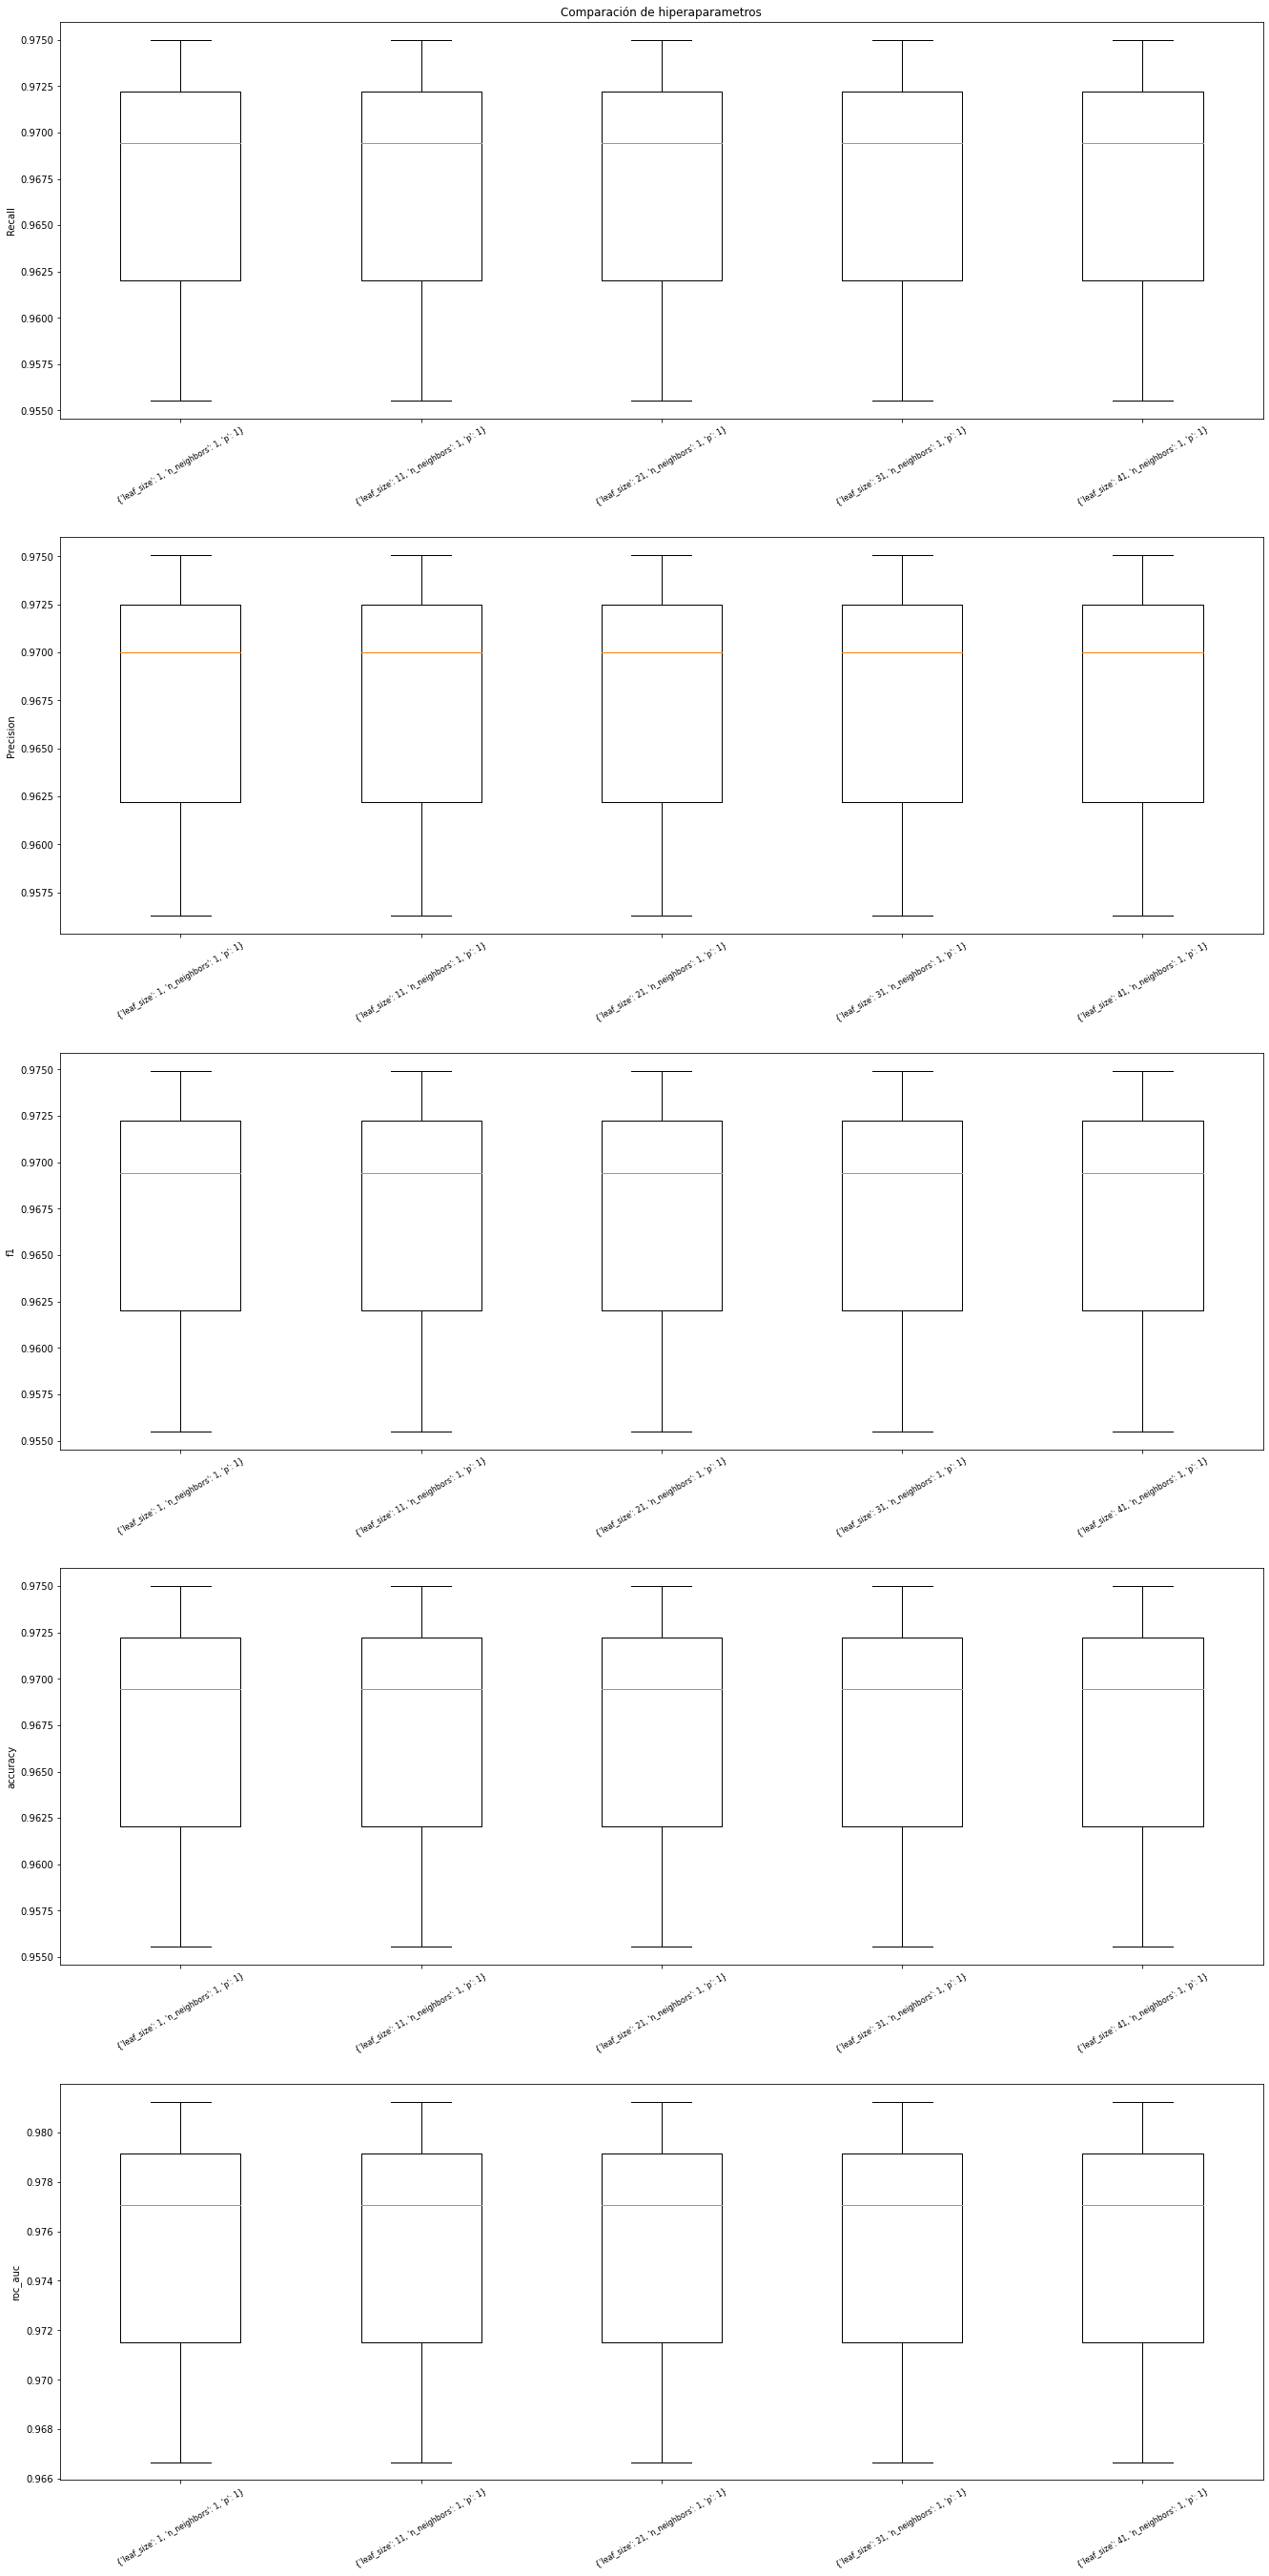

In [28]:
## Mostramos los top 5 que aparecen en los diagramas
top_recall =[]
top_precision = []
top_f1 =[]
top_accuracy = []
top_roc_auc  =[]
top_labels = []


for c in range(len(labels)):
    for score in scoring:        
        x = df['rank_test_'+score]
        if score == 'recall_macro':            
            if x[c] == 1 :
                top_recall.append(df.iloc[c,8:13].to_list())
                top_labels.append(df['params'][c]) 
        elif score == 'precision_macro':
            if x[c] == 1 :
                top_precision.append(df.iloc[c,16:21].to_list())
        elif score == 'f1_macro':
            if x[c] == 1 : 
                top_f1.append(df.iloc[c,24:29].to_list())
        elif score == 'accuracy':
            if x[c] == 1 :
                top_accuracy.append(df.iloc[c,32:37].to_list())
        elif score == 'roc_auc_ovo':
            if x[c] == 1 :
                top_roc_auc.append(df.iloc[c,40:45].to_list())


fig, ax = plt.subplots(5,1)

ax[0].boxplot(top_recall,labels=top_labels)
ax[0].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[0].set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Comparación de hiperaparametros',
    ylabel='Recall'
    )

ax[1].boxplot(top_precision,labels=top_labels)
ax[1].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[1].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Precision'
)

ax[2].boxplot(top_f1,labels=top_labels)
ax[2].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[2].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='f1'
)


ax[3].boxplot(top_accuracy,labels=top_labels)
ax[3].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[3].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='accuracy'
)


ax[4].boxplot(top_roc_auc,labels=top_labels)
ax[4].set_xticklabels(labels=top_labels,rotation=30, fontsize=8)
ax[4].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='roc_auc'
)
fig.subplots_adjust(left=0.08, right=3, bottom=0.05, top=9,
                    hspace=0.3, wspace=0.3)

plt.show()
            

 




In [29]:
# Comparacion de hipotesis con accuracy
alpha = 0.05
F_statistic, pVal = stats.kruskal(top_accuracy[0],top_accuracy[1], top_accuracy[2],top_accuracy[3],top_accuracy[4])

print ('p-valor KrusW:', pVal)

if pVal <= alpha:
    print('Rechazamos la hipótesis: los modelos son diferentes\n')
    stacked_data = np.vstack((top_accuracy[0],top_accuracy[1], top_accuracy[2],top_accuracy[3],top_accuracy[4])).ravel()
    stacked_model = np.vstack((np.repeat('modelLR',CV),np.repeat('modelLDA',CV),np.repeat('modelKNN',CV))).ravel()    
    MultiComp = MultiComparison(stacked_data, stacked_model)
    comp = MultiComp.allpairtest(stats.ttest_rel, method='Holm')
    print (comp[0])    
    print(MultiComp.tukeyhsd(alpha=0.05))
else:
    print('Aceptamos la hipótesis: los modelos son iguales')

# Como los modelos son iguales aceptamos el modelo mas sencillo, osea el parametro con la hoja mas grande ya que es el mas rapido 

p-valor KrusW: 1.0
Aceptamos la hipótesis: los modelos son iguales
